In [58]:
# Importing the necessary Libraries

import numpy as np
import pandas as pdi
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import sklearn
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split

Dataset: We managed to find a dataset on Kaggle which already divided the tumor images into four different categories, which are glioma tumor, meningioma tumor, pituitary tumor, and no tumor. Further, the images are already split in to Training and Testing Folders. 

Dataset Link: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

The first part of this project involves detecting the presence or absence of brain tumors if a tumor is present classify the tumor into one of the three categories mentioned above.

- Meningioma is the most common type of brain tumor.  Most  Meningiomas are classified as benign tumors meaning it is a mass of cells that grows slowly and remains localized (does not spread to other parts of the brain.)
- Gliomas are also common in adults and be either benign or malignant with malignant meaning that it is a mass of cells that grows uncontrollably and has the ability to spread to other nearby tissues in the brain. The further classification of gliomas depend on the specific types of glioma and it's aggressiveness which can range from Grade I - IV (grade IV being the most aggressive).
- Pituitary Tumors is the least common among the three and are typically classified as benign.

## 1. Loading the Dataset

In [2]:
# Loading the Training Dataset directory

# Define the path
train_dir = './Dataset/Training/'

# Creating a dictionary to associate the name of each class (tumor type - key) with the nnumber of images in the corresponding folder(value).

number_classes = {'no_tumor' : len(os.listdir('./Dataset/Training/no_tumor')),
                 'glioma_tumor' : len(os.listdir('./Dataset/Training/glioma_tumor')),
                 'meningioma_tumor' : len(os.listdir('./Dataset/Training/meningioma_tumor')),
                 'pituitary_tumor' : len(os.listdir('./Dataset/Training/pituitary_tumor'))}

In [3]:
print(number_classes)

{'no_tumor': 395, 'glioma_tumor': 826, 'meningioma_tumor': 822, 'pituitary_tumor': 827}


## 2. Data Exploration (Exploratory Analysis)

Text(0.5, 1.0, 'No. of Images for each Brain Tumor Type')

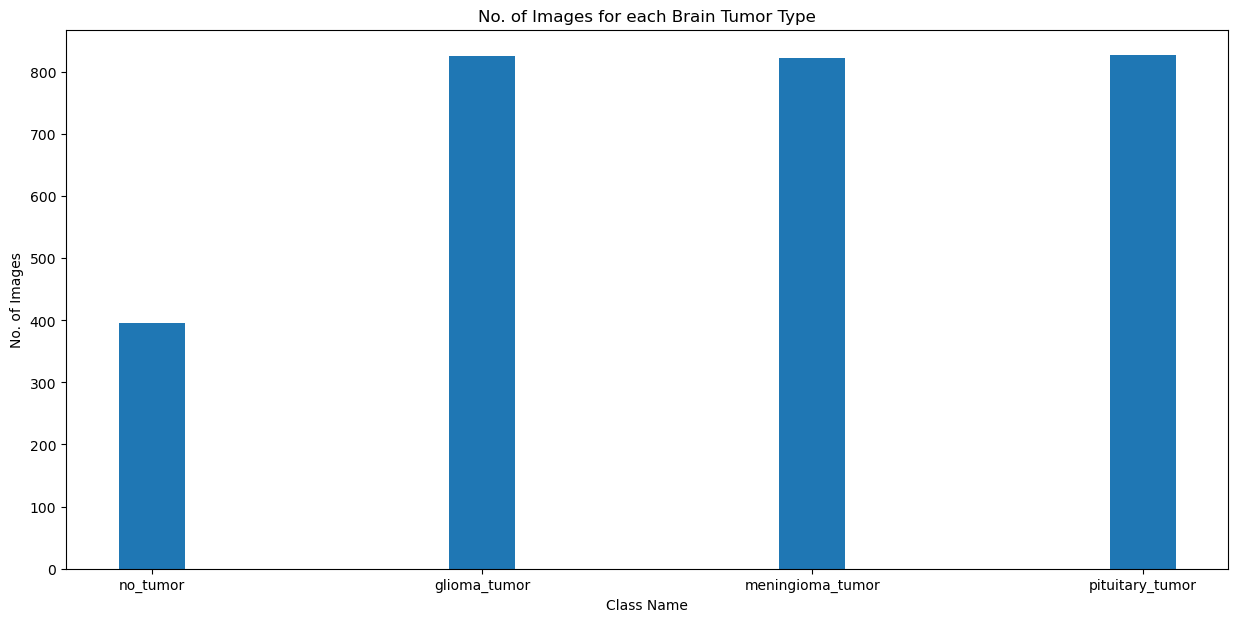

In [4]:
# Creating a class frequency bar-plot

plt.subplots(figsize=(15, 7))
plt.bar(number_classes.keys(), number_classes.values(), width = .2)
plt.xlabel('Class Name')
plt.ylabel('No. of Images')
plt.title('No. of Images for each Brain Tumor Type')

In [5]:
# Loading the images...

def get_images(base_dir, path, extension = ".jpg"):
    return [ fn for fn in os.listdir(f'{base_dir}{path}') if fn.endswith(extension)]

no_tumor_images = get_images(train_dir, "no_tumor")
glioma_images = get_images(train_dir, "glioma_tumor")
meningioma_images = get_images(train_dir, "meningioma_tumor")
pituitary_images = get_images(train_dir, "pituitary_tumor")

In [7]:
#glioma_images

In [8]:
# Randomly selecting 5 images from each class

def select_random_image(image):
    return np.random.choice(image, 5, replace = False)

select_no_tumor = select_random_image(no_tumor_images)
select_glioma = select_random_image(glioma_images)
select_meningioma = select_random_image(meningioma_images)
select_pituitary = select_random_image(pituitary_images)

In [9]:
select_no_tumor

array(['image(160).jpg', 'image(124).jpg', 'image(207).jpg',
       'image(143).jpg', 'image(200).jpg'], dtype='<U14')

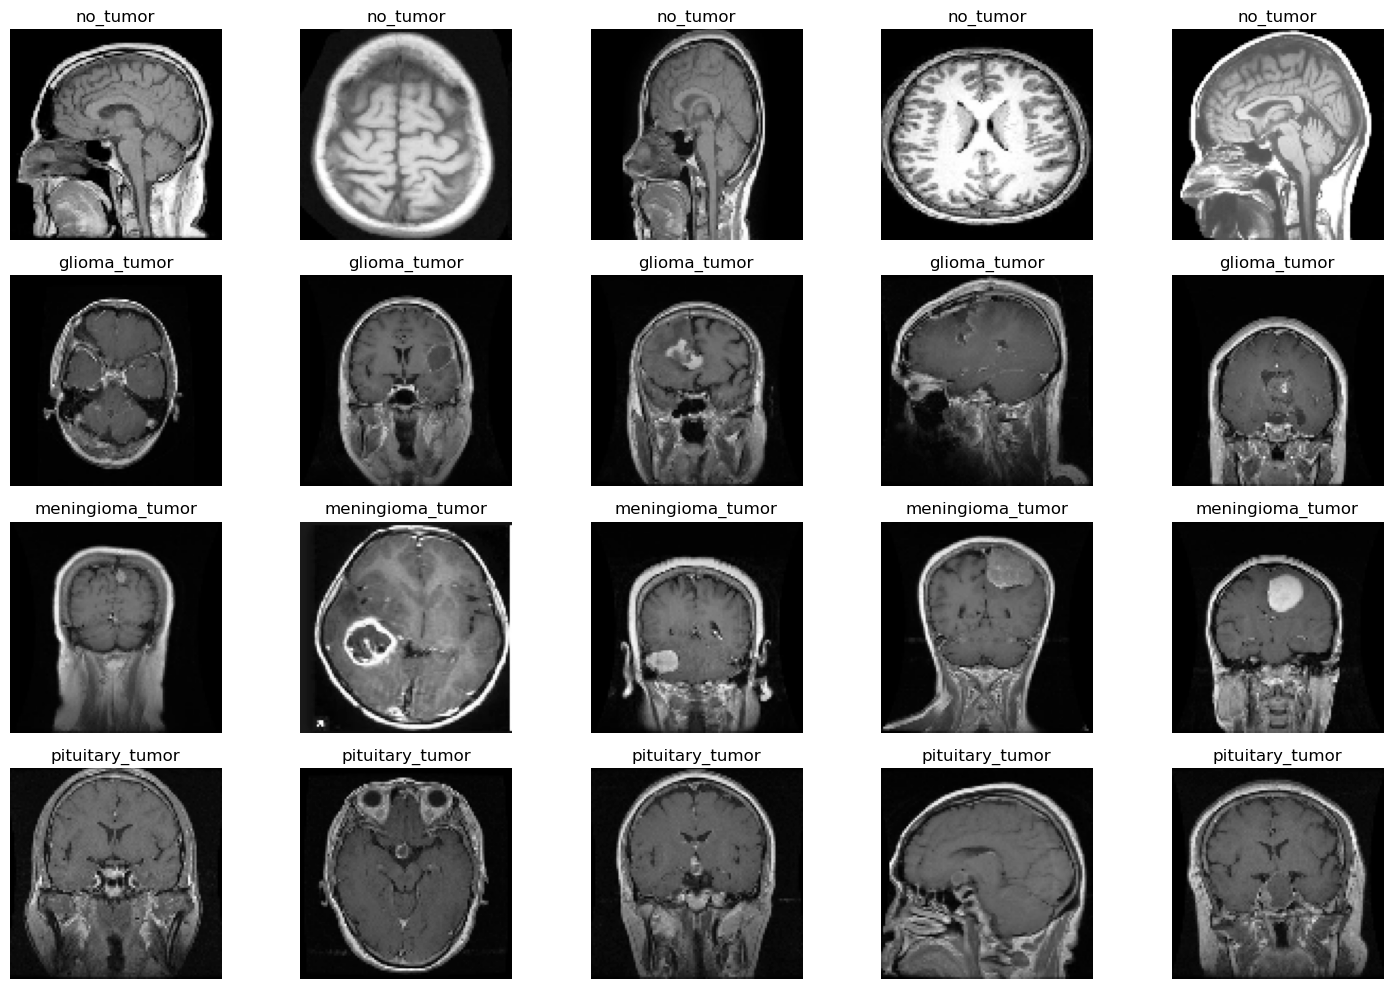

In [10]:
# Plotting a matrix of images selected

# Function to plot images
def plot_images(image_array, class_name, start_index, rows, cols):
    for i in range(len(image_array)):
        fp = f'{train_dir}{class_name}/{image_array[i]}'
        ax = fig.add_subplot(rows, cols, start_index + i)
        fn = load_img(fp, target_size=(100, 100), color_mode='grayscale')
        plt.imshow(fn, cmap="Greys_r")
        plt.title(class_name)
        plt.axis('off')

# Create a figure
fig = plt.figure(figsize=(15, 10))

# Plotting no tumor images
plot_images(select_no_tumor, "no_tumor", 1, 4, 5)

# Plotting glioma images
plot_images(select_glioma, "glioma_tumor", 6, 4, 5)

# Plotting meningioma images
plot_images(select_meningioma, "meningioma_tumor", 11, 4, 5)

# Plotting pituitary images
plot_images(select_pituitary, "pituitary_tumor", 16, 4, 5)

plt.tight_layout()
plt.show()


In [11]:
# Flattening the images into a 1D vector and creating a 2D array of the entire images, with each row of the 2D
# array representing an image.

def img2mat(path, filename, size=(64,64)):
    for fn in filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, color_mode = 'grayscale')
        
        # Convert the image into a matrix
        img_vector = image.img_to_array(current_image)
        # Turn current_image into a vector
        img_vector = [img_vector.ravel()]
        try:
            # Concatenate different images
            full_mat = np.concatenate((full_mat, img_vector))
        except:
            # If full matrix is not defined during the first ireration, create one.
            full_mat = img_vector
    return full_mat

# Run the function on our folders

no_tumor_images = img2mat(f'{train_dir}no_tumor/', no_tumor_images)
glioma_images = img2mat(f'{train_dir}glioma_tumor/', glioma_images)
meningioma_images = img2mat(f'{train_dir}meningioma_tumor/', meningioma_images)
pituitary_images = img2mat(f'{train_dir}pituitary_tumor/', pituitary_images)

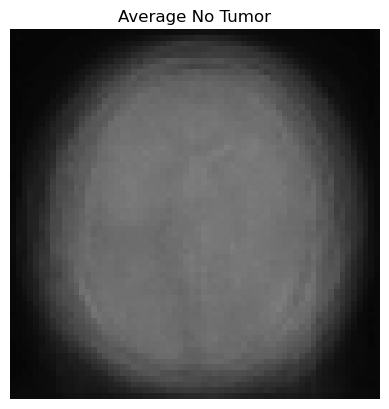

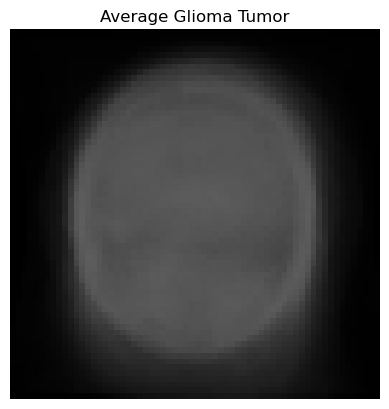

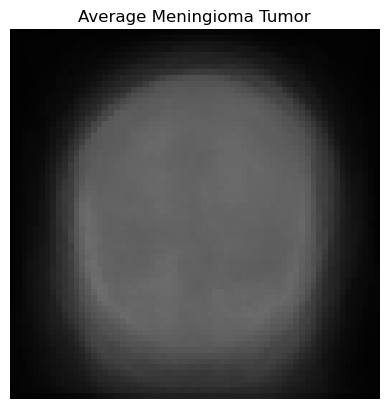

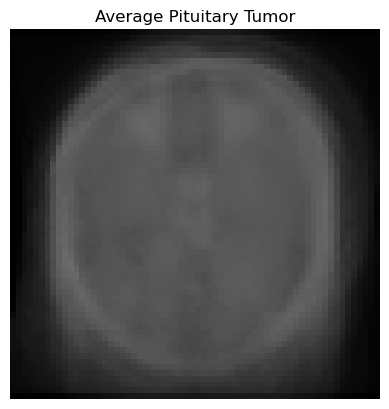

In [12]:
# Creating a function that will take the average for each category. 

def mean_of_images(full_mat, title, size = (64, 64)):
    # Calculate the average
    avg_image = np.mean(full_mat, axis = 0)
    # Reshape it back into a matrix
    avg_image = avg_image.reshape(size)
    plt.imshow(avg_image, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return avg_image

# Running the function on our 4 matrices

no_tumor_mean = mean_of_images(no_tumor_images, 'No Tumor')
glioma_mean = mean_of_images(glioma_images, 'Glioma Tumor')
meningioma_mean = mean_of_images(meningioma_images, 'Meningioma Tumor')
pituitary_mean = mean_of_images(pituitary_images, 'Pituitary Tumor')

This is essentially the average image for each of the 4 categories in the dataset.
Now,  I will compare the average of no_tumor images with each of the other three categories and plot an image for the same...
this helps visualize and analyze the typical characteristics of each tumor type.

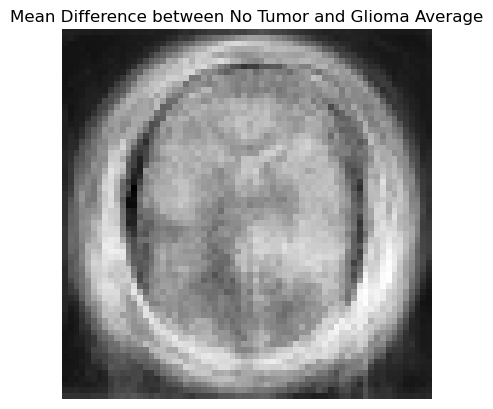

In [13]:
# 1. Glioma Tumor VS No Tumor
difference_mean = no_tumor_mean - glioma_mean
plt.imshow(difference_mean, cmap='Greys_r')
plt.title(f'Mean Difference between No Tumor and Glioma Average')
plt.axis('off')
plt.show()

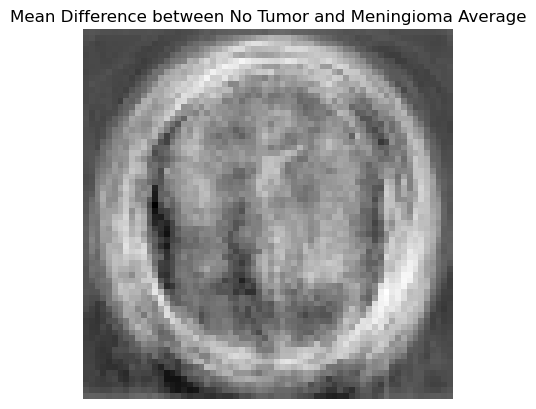

In [14]:
# 2. Meningioma Tumor VS No Tumor

difference_mean = no_tumor_mean - meningioma_mean
plt.imshow(difference_mean, cmap='Greys_r')
plt.title(f'Mean Difference between No Tumor and Meningioma Average')
plt.axis('off')
plt.show()

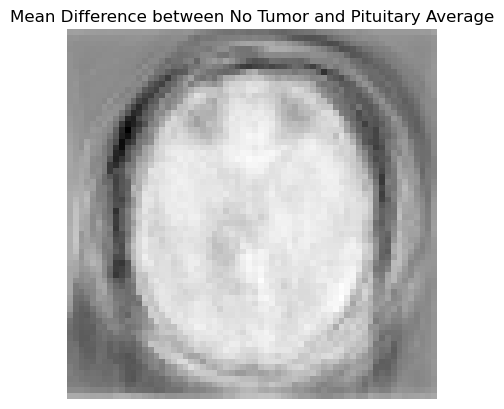

In [15]:
# 3. Pituitary Tumor vs No Tumor

difference_mean = no_tumor_mean - pituitary_mean
plt.imshow(difference_mean, cmap='Greys_r')
plt.title(f'Mean Difference between No Tumor and Pituitary Average')
plt.axis('off')
plt.show()

## 3. Data Preparation

In [33]:
# Train and Test Sets : I have created a function here which will generate the training and testing sets by combining all images into just a training and test set.

def train_test_set(size, labels):
    X_train, X_test, y_train, y_test = [], [], [], []
    
    # Training Set
    for label in labels:
        fp = os.path.join('./Dataset/', 'Training/', label)
        # To display the progress
        for unique in tqdm(os.listdir(fp)):
            # Read the images
            image = cv2.imread(os.path.join(fp, unique))
            # Set the image size the the defined size...
            image = cv2.resize(image, (size, size))
            # Append the image to the X_train set
            X_train.append(image)
            # Append the corresponding label to the y_train set
            y_train.append(label)
            
      # Testing Set
    for label in labels:
        fp = os.path.join('./Dataset/', 'Testing/', label)
        # To display the progress
        for unique in tqdm(os.listdir(fp)):
            # Read the images
            image = cv2.imread(os.path.join(fp, unique))
            # Set the image size the the defined size...
            image = cv2.resize(image, (size, size))
            # Append the image to the X_test set
            X_train.append(image)
            # Append the corresponding label to the y_test set
            y_train.append(label)
    return  X_train, y_train

In [34]:
# Train and Test Sets : created a function here which will generate the training and testing sets (According to original divisions).

def train_test_set_2(size, labels):
    X_train, X_test, y_train, y_test = [], [], [], []
    
    # Training Set
    for label in labels:
        fp = os.path.join('./Dataset/', 'Training/', label)
        # To display the progress
        for unique in tqdm(os.listdir(fp)):
            # Read the images
            image = cv2.imread(os.path.join(fp, unique))
            # Set the image size the the defined size...
            image = cv2.resize(image, (size, size))
            # Append the image to the X_train set
            X_train.append(image)
            # Append the corresponding label to the y_train set
            y_train.append(label)
            
      # Testing Set
    for label in labels:
        fp = os.path.join('./Dataset/', 'Testing/', label)
        # To display the progress
        for unique in tqdm(os.listdir(fp)):
            # Read the images
            image = cv2.imread(os.path.join(fp, unique))
            # Set the image size the the defined size...
            image = cv2.resize(image, (size, size))
            # Append the image to the X_test set
            X_test.append(image)
            # Append the corresponding label to the y_test set
            y_test.append(label)
    return  X_train, X_test, y_train, y_test

In [35]:
# Image folder labels

labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Calling the function..

X_train, y_train = train_test_set(150, labels)

100%|██████████| 74/74 [00:00<00:00, 252.67it/s]


In [36]:
# Two Sets

X2_train, X2_test, y2_train, y2_test = train_test_set_2(150, labels)

100%|██████████| 74/74 [00:00<00:00, 212.61it/s]


In [37]:
# Converting into numpy arrays

X_train = np.array(X_train)
y_train = np.array(y_train)

X2_train = np.array(X2_train)
y2_train = np.array(y2_train)
X2_test = np.array(X2_test)
y2_test = np.array(y2_test)


In [38]:
# Let's check the shapes now...

print('Shapes of the sets')
print(f'{"-"*30}\n')
print('First Set:')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print('Second Set:')
print(f'X_train: {X2_train.shape}')
print(f'y_train: {y2_train.shape}')
print(f'X_test: {X2_test.shape}')
print(f'y_test: {y2_test.shape}')

Shapes of the sets
------------------------------

First Set:
X_train: (3264, 150, 150, 3)
y_train: (3264,)
Second Set:
X_train: (2870, 150, 150, 3)
y_train: (2870,)
X_test: (394, 150, 150, 3)
y_test: (394,)


The sets have 3 channels which indicates that they are in RGB format.

## 4. Shuffling and the Encoding the Training and Testing Sets

In [39]:
# First Set

X_train, y_train = shuffle(X_train, y_train, random_state = 0)

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0)

In [40]:
# Second Set

# Shuffling the dataset to randomize the order

X2_train, y2_train = shuffle(X2_train, y2_train, random_state = 0)
X2_test, y2_test = shuffle(X2_test, y2_test, random_state = 0)

In [41]:
# Encoding...

# Label encoding...

y1_train = LabelEncoder().fit_transform(y_train)
y1_test = LabelEncoder().fit_transform(y_test)
y2_train = LabelEncoder().fit_transform(y2_train)
y2_test = LabelEncoder().fit_transform(y2_test)

In [42]:
# One hot Encoding..

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y3_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y3_test = tf.keras.utils.to_categorical(y_test)

## 5. CNN Models...

In [43]:
# Function to generate line plots based on the history of the model to evaluate it.

def generate_plot(hist):
    fig, ax = plt.subplots(figsize = (10, 5))
    plt.plot(hist.history['accuracy'], label='Accuracy')
    plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc = 'upper right')
    plt.show()

In [44]:
def model_1(shape, labels, X_train, X_test, y_train, y_test, loss = 'categorical_crossentropy'):
    # Define the model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_uniform', input_shape = shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(labels), activation = 'softmax'))
    print('CNN Layer Model Summary \n')
    print(model.summary())
                           
    # Compile the model
    model.compile(optimizer = 'adam', loss = loss, metrics = ['accuracy'])
    
    # Fit the model
    history = model.fit(X_train, y_train, epochs = 15, validation_data = (X_test, y_test))
    
    # Plotting the train and validation accuracy line plots
    generate_plot(history)
    
    print()
    print()
    print()
    
    # Accuracy
    print('\n Model Accuracy and Loss \n')
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_acc}')
    print(f'Test Loss: {test_loss}')
    
    print()
    print()
    print()
    
    # Prediction
    pred = np.argmax(model.predict(X_test), axis = 1)
    y_test_new = np.argmax(y_test, axis = 1)
    
    # Classification report
    print('\n Classification report \n')
    report = classification_report(y_test_new, pred)
    print(report)
    
    print()
    print()
    print()
    
    # Heatmap
    fig, ax = plt.subplots(figsize = (10, 8))
    sns.heatmap(confusion_matrix(y_test_new, pred), xticklabels = labels, yticklabels = labels, annot = True, cmap = 'viridis', fmt = 'g')
    plt.title('Heatmap', y=1.05)
    

In [45]:
shape = X_train.shape[1:]
shape

(150, 150, 3)

CNN Layer Model Summary 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin 

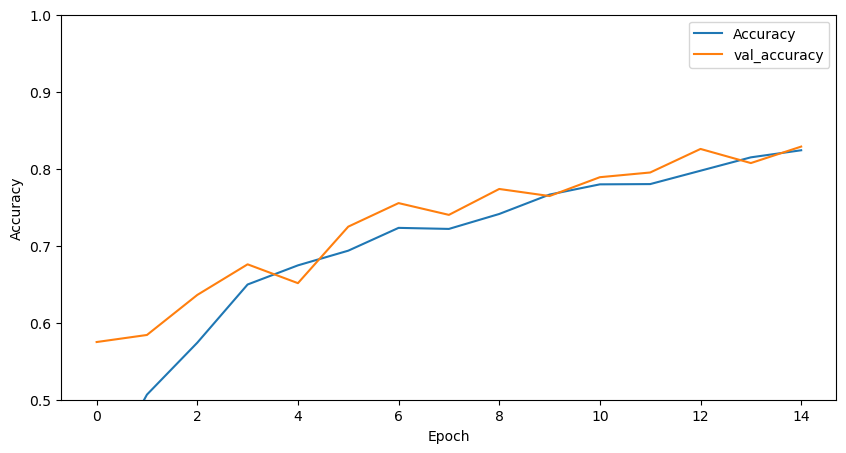





 Model Accuracy and Loss 

11/11 [==============================] - 1s 65ms/step - loss: 0.6095 - accuracy: 0.8287
Test Accuracy: 0.8287461996078491
Test Loss: 0.609499990940094



11/11 [==============================] - 1s 66ms/step

 Classification report 

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.75      0.70      0.72        82
           2       0.75      0.81      0.78        48
           3       0.91      0.94      0.93        87

    accuracy                           0.83       327
   macro avg       0.82      0.82      0.82       327
weighted avg       0.83      0.83      0.83       327






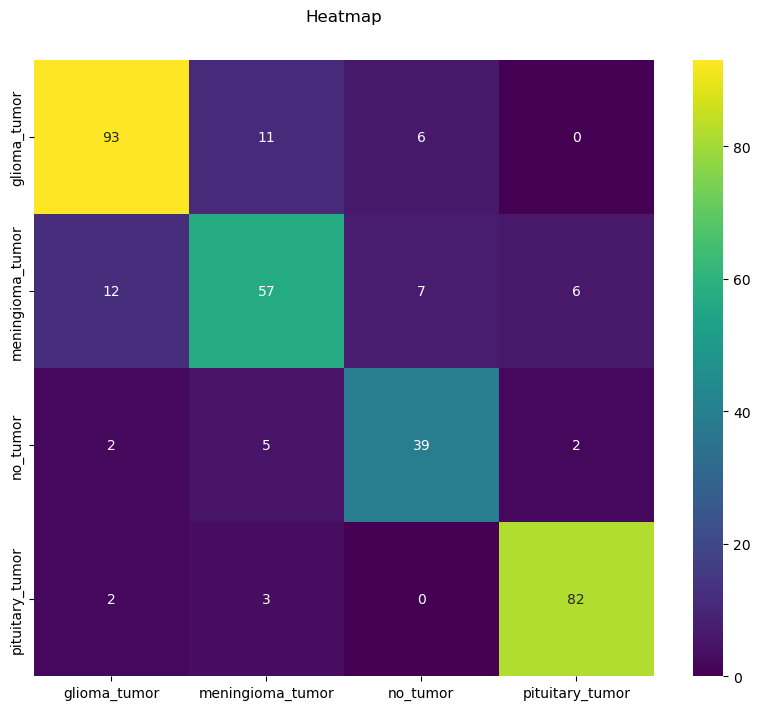

In [46]:
model_1(shape, labels, X_train, X_test, y3_train, y3_test, loss = 'categorical_crossentropy')

## Second Presentation
### Using Transfer Learning to improve the performance of the Model.

Will try to use EfficientNetB0 as this keras application has a good trade-off between accuracy and time(ms) per inference step for both CPU and GPU.
More about this at: https://keras.io/api/applications/

In [53]:
# Defining the model

def transfer_learning_performance(shape, labels, X_train, X_test, y_train_one_hot_encoded, y_test_one_hot_encoded):
    
    # Loading the Pre-trained model
    efficient_net_b0 = EfficientNetB0(input_shape = shape, weights='imagenet', include_top=False)
    
    # Model Definition
    model = efficient_net_b0.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=efficient_net_b0.input, outputs = model)
    
    #Compiling the Model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    
    # Fitting the Model on the dataset
    history = model.fit(X_train, y_train_one_hot_encoded, validation_data = (X_test, y3_test), epochs = 12, verbose = 1, batch_size = 32)
    print('\nModel Evaluation\n')
    generate_plot(history)
    print()
    
    # Accuracy
    print('\nModel Accuracy and Loss\n')
    test_loss, test_acc = model.evaluate(X_test, y3_test)
    print(f'Test Accuracy: {test_acc}')
    print(f'Test Loss: {test_loss}')
    print()
    
    # Prediction
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_test_new = np.argmax(y3_test, axis=1)
    
    # Classification Report
    print('\nClassification Report\n')
    report = classification_report(y_test_new, pred)
    print(report)
    print()
    
    # Heatmap
    fig,ax = plt.subplots(figsize = (10, 8))
    sns.heatmap(confusion_matrix(y_test_new, pred), xticklabels=labels, yticklabels=labels, annot=True,
               cmap = 'viridis', fmt = 'g')
    plt.title('Heatmap', y = 1.05)

In [59]:
# Saving the model and a tflite model

def save_transfer_learning_model(shape, X_train, X_test, y_train, y_test):
    # Transfer learning Model
    efficient_net_b0 = EfficientNetB0(input_shape = shape, weights='imagenet', include_top=False)
    
    # Model Definition
    model = efficient_net_b0.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    
    # Overfitting Reduction
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(4, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=efficient_net_b0.input, outputs = model)
    
    # Compiling the Model
    model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
    
    # Saving the model
    checkpoint = ModelCheckpoint('efficient_net_b0.h5', monitor='val_accuracy', save_best_only=True, mode='auto',verbose=1)
    
    #Reduce learning rate once it saturates
    reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto', verbose=1)
    
    # Fitting the Model
    model.fit(X_train, y3_train, validation_data = (X_test, y3_test), epochs = 12, verbose = 1, batch_size = 32, callbacks = [checkpoint, reduce_lr])
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    # Converting the model to a tflite model
    tflite_model = converter.convert()
    
    # Saving the tflite model
    with open('model.tflite' , 'wb') as f:
        f.write(tflite_model)

Epoch 1/12
92/92 [==============================] - 163s 2s/step - loss: 0.4489 - accuracy: 0.8308 - val_loss: 0.6392 - val_accuracy: 0.8440
Epoch 2/12
92/92 [==============================] - 147s 2s/step - loss: 0.2064 - accuracy: 0.9319 - val_loss: 0.1818 - val_accuracy: 0.9480
Epoch 3/12
92/92 [==============================] - 148s 2s/step - loss: 0.1185 - accuracy: 0.9595 - val_loss: 0.2019 - val_accuracy: 0.9235
Epoch 4/12
92/92 [==============================] - 149s 2s/step - loss: 0.1074 - accuracy: 0.9687 - val_loss: 0.1143 - val_accuracy: 0.9664
Epoch 5/12
92/92 [==============================] - 152s 2s/step - loss: 0.0611 - accuracy: 0.9799 - val_loss: 0.0586 - val_accuracy: 0.9786
Epoch 6/12
92/92 [==============================] - 151s 2s/step - loss: 0.0693 - accuracy: 0.9775 - val_loss: 0.4282 - val_accuracy: 0.8991
Epoch 7/12
92/92 [==============================] - 152s 2s/step - loss: 0.0663 - accuracy: 0.9775 - val_loss: 0.3304 - val_accuracy: 0.9174
Epoch 8/12
92

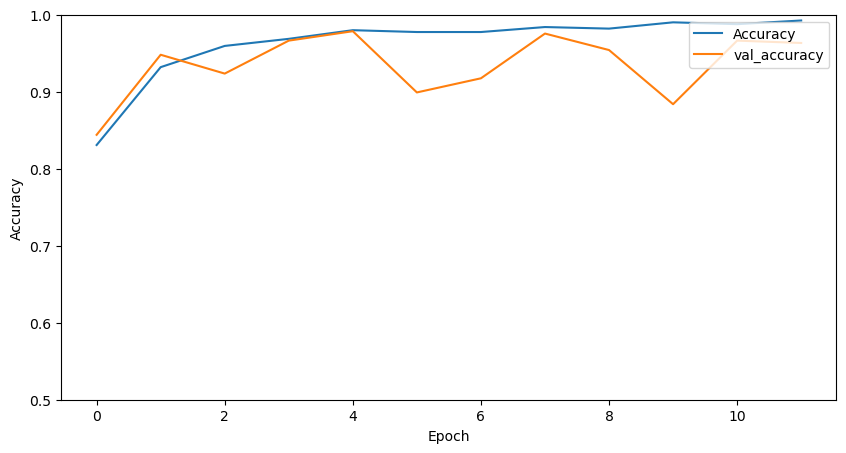



Model Accuracy and Loss

11/11 [==============================] - 3s 256ms/step - loss: 0.1314 - accuracy: 0.9633
Test Accuracy: 0.963302731513977
Test Loss: 0.13140340149402618

11/11 [==============================] - 4s 246ms/step

Classification Report

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       110
           1       0.96      0.93      0.94        82
           2       0.96      0.98      0.97        48
           3       0.95      0.99      0.97        87

    accuracy                           0.96       327
   macro avg       0.96      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327




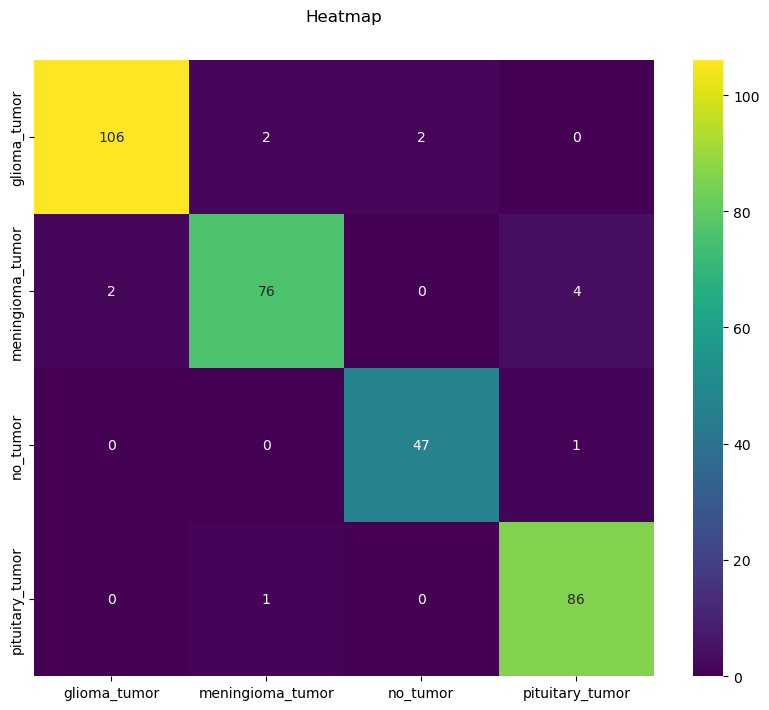

In [54]:
transfer_learning_performance(shape, labels, X_train, X_test, y3_train, y3_test)

  # Some Observations from this model
    
    1. The model accuracy becomes stable, achieving a high-value of 94-96%. Instances of misclassification are low as well. In order to rectify the occasional
        misclassification, more images can be used to train the model.
    2. This model has the better performance than the previous model and therefore will be used to implement the solution to this problem.

In [60]:
# Saving the original model, as well ad the tflite model

save_transfer_learning_model(shape, X_train, X_test, y3_train, y3_test)

Epoch 1/12
92/92 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.8274
Epoch 1: val_accuracy improved from -inf to 0.85321, saving model to efficient_net_b0.h5


C:\Users\rachitsainii\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 164s 2s/step - loss: 0.4609 - accuracy: 0.8274 - val_loss: 0.5291 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 2/12
92/92 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9482
Epoch 2: val_accuracy did not improve from 0.85321
92/92 [==============================] - 624s 7s/step - loss: 0.1542 - accuracy: 0.9482 - val_loss: 0.8208 - val_accuracy: 0.8349 - lr: 0.0010
Epoch 3/12
92/92 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9608
Epoch 3: val_accuracy improved from 0.85321 to 0.92661, saving model to efficient_net_b0.h5
92/92 [==============================] - 146s 2s/step - loss: 0.1084 - accuracy: 0.9608 - val_loss: 0.2715 - val_accuracy: 0.9266 - lr: 0.0010
Epoch 4/12
92/92 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9622
Epoch 4: val_accuracy did not improve from 0.92661
92/92 [==============================] - 146s 2s/step - loss: 0.1145 - accuracy: 0.9622 - val_l

INFO:tensorflow:Assets written to: C:\Users\RACHIT~1\AppData\Local\Temp\tmpvks7zs1c\assets


The EfficientNetB0 model will be deployed in a User Interface for Brain Tumor Detection

Performance Summary:
    
1. Manually Trained Model - (One-Hot Encoded label)
- Accuracy: 82% 
- High Model bias towards the pituitary tumour class. (Other classes have an F1 score lower than 0.9, while the latter has an F1 score of 0.94)
- The precision of each class is below 95%, these values are inadequate, as the detection and classification of brain tumors is a sensitive matter, and false predictions 
    won't be tolerated.
2. Model fitting on pre-trained model - (EfficientNetB0)
- Accuracy: 96% 
- A great improvement from the previous model. Furthermore, the model has a more stable and reliable performance.
- All the classes have an F1 score >= 97%, greatly reducing the bias previously seen in the preceding model.
- THe model attains high class precison values >=95%. Therefore, there are very few instances of false detections and classifications.